In [1]:
from matplotlib import pyplot as plt
import csv
import numpy as np
import os
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from skimage.filters import threshold_otsu
import sys

results = "C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\"
ms = 1e-3
us = 1e-6

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

sys.path.append("C:\\Networking Experiment\\artiq codes\\artiq-master\\repository\\qn_artiq_routines")
from fitting.run_modeling import get_release_recap_fit_result, release_recap_retention_at_t

### 2024.08.19

In [2]:
fnames = get_files_by_criteria(date_filters=["2024-08-19"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 14 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\14\000016582-GeneralVariableScan.h5) scanned over t_FORT_drop
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\14\000016583-GeneralVariableScan.h5) scanned over t_FORT_drop
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\15\000016584-GeneralVariableScan.h5) scanned over t_PGC_in_MOT
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\16\000016585-GeneralVariableScan.h5) scanned over t_PGC_in_MOT
file 8 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\17\000016588-GeneralVariableScan.h5) scanned over t_PGC_in_MOT
file 9 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\17\000016628-GeneralVariableScan.h5) scanned over t_FORT_drop
file 10 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\17\000016632-GeneralVariableScan.h5) scanned over t_PGC_in_MOT
file 12

### release recapture experiment

experiment: atom_loading_experiment
experiment: atom_loading_experiment


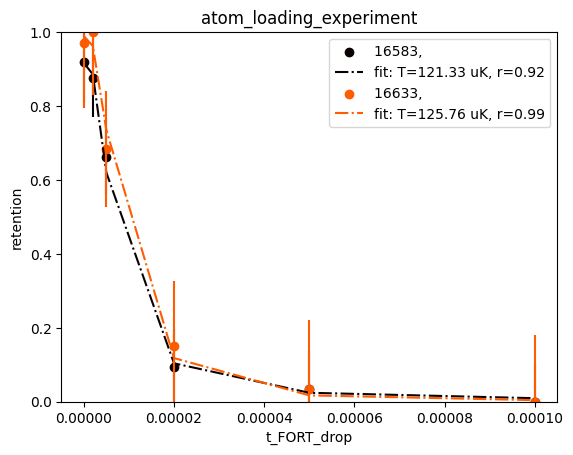

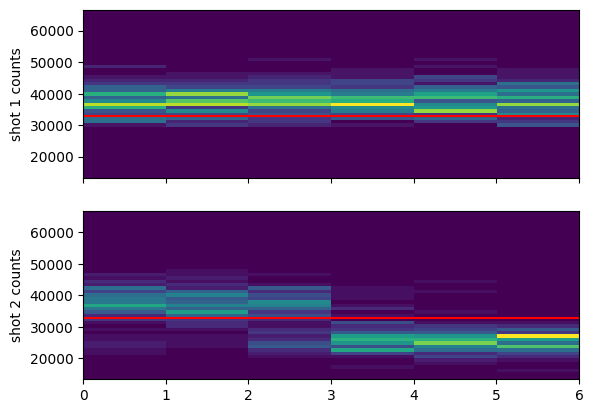

In [9]:
compare = True # compare multiple files in the same retention and loading plots

fit_data = True
trap_params = {'Tdepth': 2e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1

cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. we measure counts.

file_indices = {
    2: '', 
    12: '', 
} # the files to plot

custom_xlabel = False
# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing

if custom_xlabel:
    # xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

showhist = True
showloading = False
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'uW detuning:{(f_microwaves_dds-f_dds_clock_resonance)*1e-3:.2f}kHz'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f't_microwave_pulse:{(t_microwave_pulse)*1e6:.2f} us'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'blowaway light {"off" if blowaway_light_off else "on"}'

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    # cutoff1=cutoff2 = 31000*t_SPCM_first_shot

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,cutoff2=cutoff1)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     shot1 = photocounts[i*n_measurements:(i+1)*n_measurements]
        #     shot2 = photocounts2[i*n_measurements:(i+1)*n_measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # # fig.tight_layout()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        xsteps = xsteps_xform(scan_sequence1)[loading > 0]
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        if not fit_data:
            ax_ret.plot(xsteps, retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps, retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)
            ax_ret.plot(xsteps, fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')

            # # hi_res_t_steps_us = np.linspace(t_steps_us[0], t_steps_us[-1], 100)
            # hi_res_t_steps_us = np.linspace(0, 100, 100)

            # this works fine if I do it in the next cell, with the exact same definitions, but here it fails
            # fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            # print(fit_retention)
        
            # fit_xsteps = np.linspace(xsteps[0], xsteps[-1], 100)
            # ax_ret.plot(fit_xsteps, fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps, retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps, loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps, loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps, loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [4]:
hi_res_t_steps_us = np.linspace(0, 100, 100)
fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

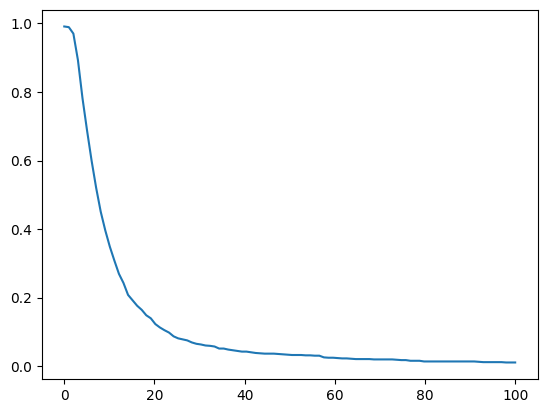

In [5]:
plt.plot(hi_res_t_steps_us,fit_retention)

In [32]:
t_steps_us = scan_sequence1[loading > 0]*1e6

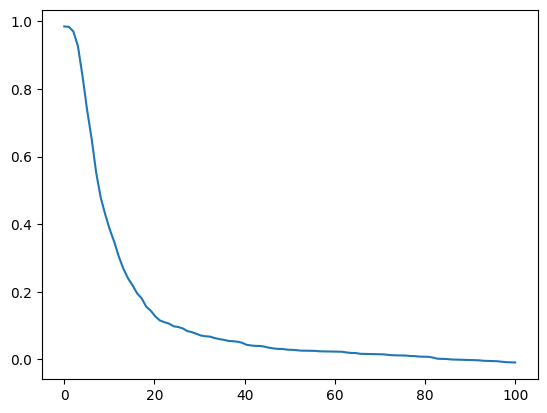

In [31]:
hi_res_t_steps_us = np.linspace(t_steps_us[0], t_steps_us[-1], 100)
fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
plt.plot(hi_res_t_steps_us,fit_retention)

In [21]:
hi_res_t_steps_us

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

In [16]:
hi_res_t_steps_us

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

In [12]:
popt

array([1.23351937e-04, 9.94811783e-01])

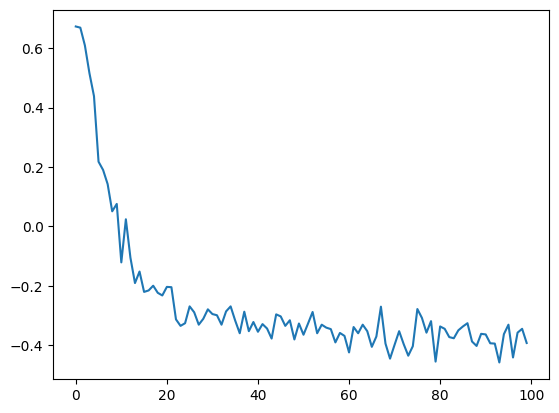

In [10]:
plt.plot(fit_retention)

In [ ]:
# check that we're using a good threshold 
fig,ax = plt.subplots()
ax.hist(photocounts,bins=50)
otsu_cutoff = threshold_otsu(photocounts)
print(otsu_cutoff)
ax.axvline(otsu_cutoff,label='otsu',color='red')
ax.axvline(cutoff1,label='manual',color='grey')
ax.legend()

In [ ]:
# this is the first experiment to measure the temperature of our single atoms in the dipole trap

f = h5py.File(os.path.join(results, "2024-08-19\\14\\000016583-GeneralVariableScan_atom_loading_scan_over_t_FORT_drop.h5"))
[x for x in f['datasets']]

In [13]:
n_measurements = np.uint(f['datasets']['n_measurements'])
counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]
t_delay_arr = np.array([0.0, 2.0, 5.0, 20.0, 50.0, 100.])*us

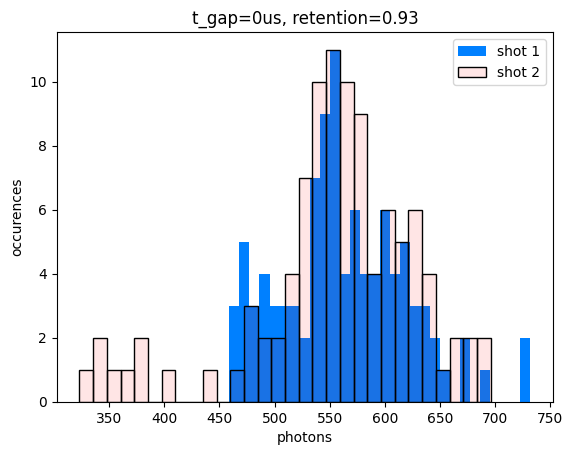

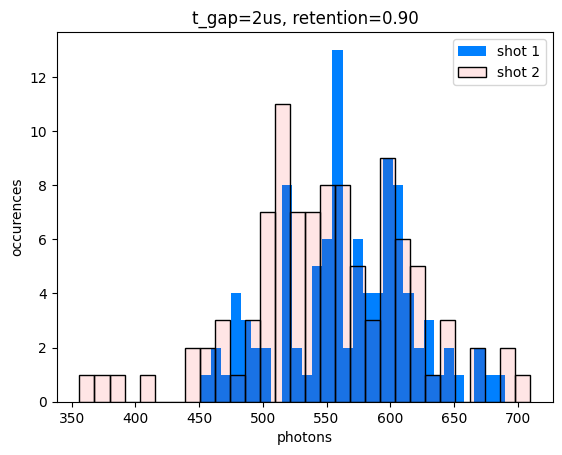

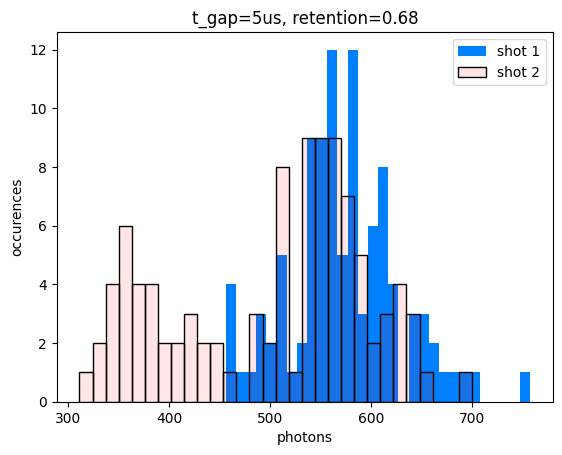

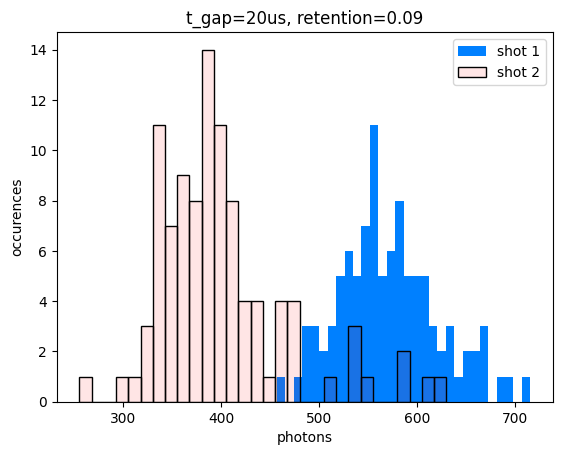

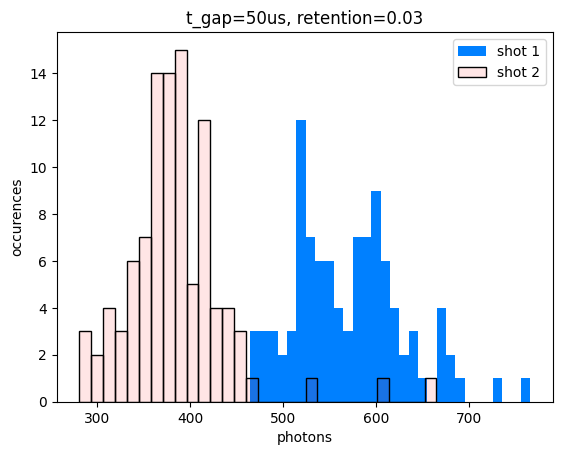

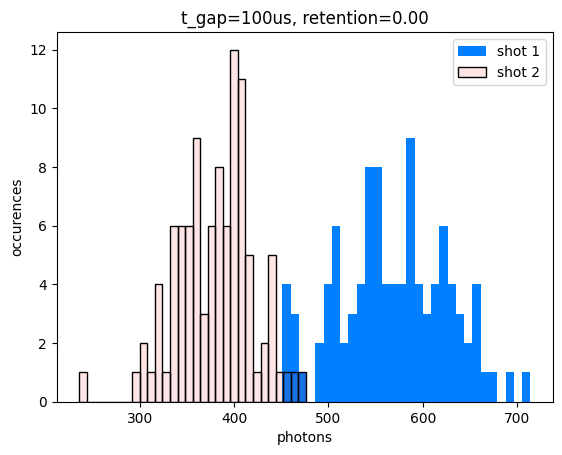

In [18]:
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
#cutoff = [210]*4
cutoff = [480]*6

retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))

n_atoms_loaded_array = np.zeros(len(t_delay_arr))

for i,t in enumerate(t_delay_arr):
    shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
    shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
    plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
    plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    
    plt.title(f"t_gap={t/us:.0f}us, retention={retention_fraction:.2f}")
    plt.ylabel("occurences")
    plt.xlabel("photons")
    plt.legend()
    plt.show()

# for i,t in enumerate(t_delay_arr):
#     shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
#     shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
#     plt.hist(shot1,bins=50, facecolor=(0.0, 0.0, 1.0, 1))
#     plt.hist(shot2,bins=50, facecolor=(1.0, 0.0, 0.0, 0.5)) #edgecolor=(1, 0.5, 0.2, 1),
#     plt.title(f"t={t/us:.0f}us")
#     plt.show()
#     atoms_loaded = [x > cutoff[i] for x in shot1]
#     n_atoms_loaded = sum(atoms_loaded)
#     atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
#     retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
#     retention_array[i] = retention_fraction
#     loading_rate_array[i] = n_atoms_loaded/n_measurements


Text(0.5, 0, 't (us)')

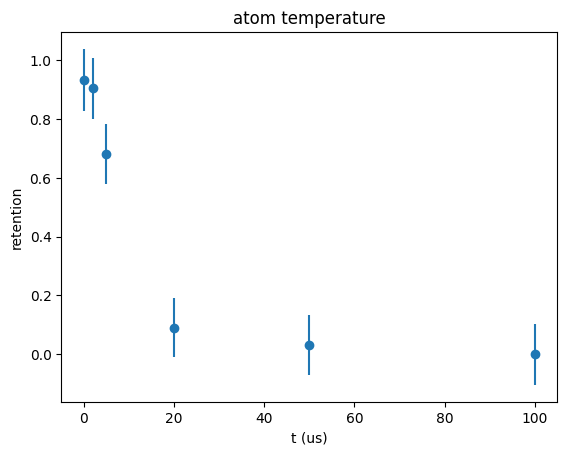

In [30]:
# plt.scatter(t_delay_arr/us, retention_array/retention_array[0])
# t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
# tau = 1.75
# plt.title('atom temperature')
# # plt.plot(t_pts,np.exp(-t_pts/tau),label=f"tau={tau} (s)")
# plt.ylabel("retention (normalized)")
# plt.xlabel("t (us)")
# # plt.xlim((0,1.1))
# # plt.legend()

plt.scatter(t_delay_arr/us, retention_array)
t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
plt.title('atom temperature')
plt.errorbar(t_delay_arr/us,retention_array,1/np.sqrt(n_atoms_loaded_array),ls='none')
plt.ylabel("retention")
plt.xlabel("t (us)")
# plt.xlim((0,1.1))
# plt.legend()

In [20]:
n_atoms_loaded_array

array([90., 94., 94., 99., 95., 92.])

In [21]:
retention_array

array([0.93333333, 0.90425532, 0.68085106, 0.09090909, 0.03157895,
       0.        ])

Text(0.5, 0, 'minutes')

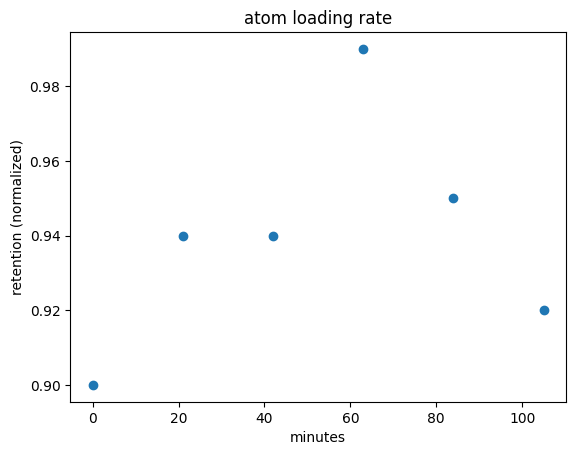

In [23]:
time = np.linspace(0,60+45,6)
plt.scatter(time,loading_rate_array)
plt.title('atom loading rate')
# plt.plot(t_pts,np.exp(-t_pts/tau),label=f"tau={tau} (s)")
plt.ylabel("retention (normalized)")
plt.xlabel("minutes")

## November 2023

### 2023.11.20

In [2]:
# this is the first experiment to measure the temperature of our single atoms in the dipole trap

f = h5py.File(os.path.join(results, "2023-11-20\\11\\000007872-SingleAtomTemperature.h5"))
[x for x in f['datasets']]

['AOM_A1_power',
 'AOM_A2_power',
 'AOM_A3_power',
 'AOM_A4_power',
 'AOM_A5_power',
 'AOM_A6_power',
 'FORT_monitor',
 'MOT1_monitor',
 'MOT2_monitor',
 'MOT3_monitor',
 'MOT4_monitor',
 'MOT5_monitor',
 'MOT6_monitor',
 'MOT_switchyard_monitor',
 'atom_counts_threshold',
 'atom_retention',
 'bins',
 'do_PGC_in_MOT',
 'n_measurements',
 'no_first_shot',
 'p_cooling_DP_MOT',
 'photocount_bins',
 'photocounts',
 'photocounts2',
 'scan_datasets',
 't_delay_between_shots']

In [6]:
n_measurements = np.uint(f['datasets']['n_measurements'])
counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]
t_delay_arr = np.array([1.0, 10.0, 50.0, 100.])*us

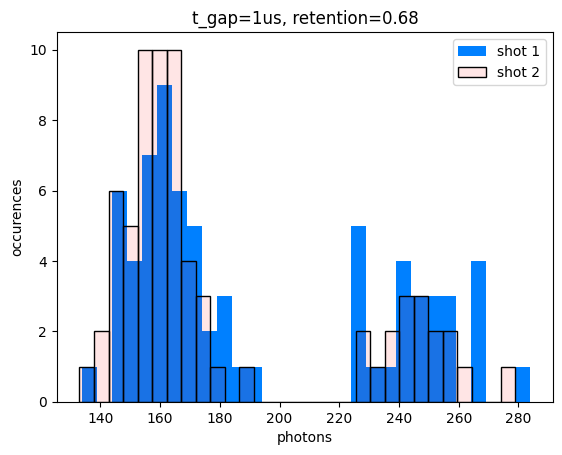

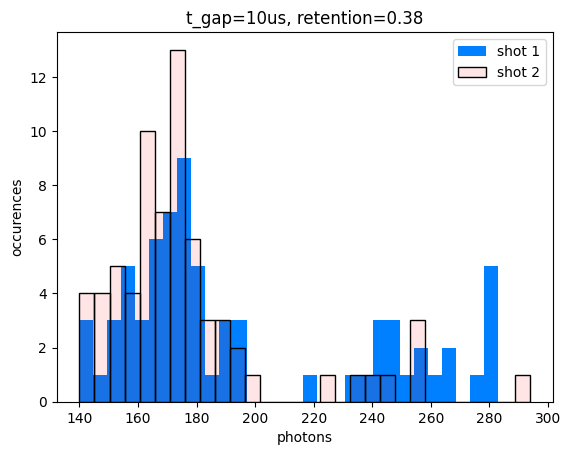

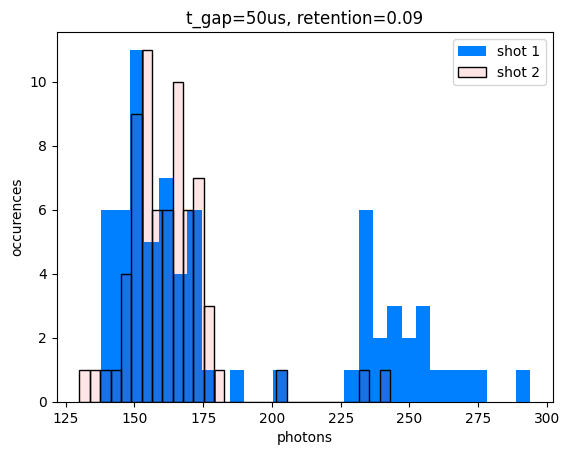

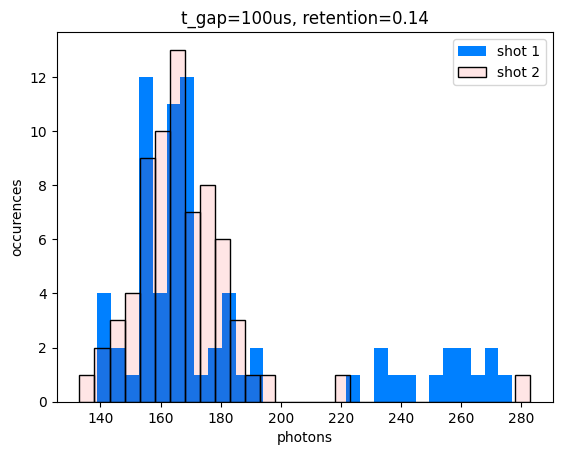

In [17]:
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = [210]*4
retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))

n_atoms_loaded_array = np.zeros(len(t_delay_arr))

for i,t in enumerate(t_delay_arr):
    shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
    shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
    plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
    plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
    
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    plt.title(f"t_gap={t/us:.0f}us, retention={retention_fraction:.2f}")
    plt.ylabel("occurences")
    plt.xlabel("photons")
    plt.legend()
    plt.show()

# for i,t in enumerate(t_delay_arr):
#     shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
#     shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
#     plt.hist(shot1,bins=50, facecolor=(0.0, 0.0, 1.0, 1))
#     plt.hist(shot2,bins=50, facecolor=(1.0, 0.0, 0.0, 0.5)) #edgecolor=(1, 0.5, 0.2, 1),
#     plt.title(f"t={t/us:.0f}us")
#     plt.show()
#     atoms_loaded = [x > cutoff[i] for x in shot1]
#     n_atoms_loaded = sum(atoms_loaded)
#     atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
#     retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
#     retention_array[i] = retention_fraction
#     loading_rate_array[i] = n_atoms_loaded/n_measurements

Text(0.5, 0, 't (s)')

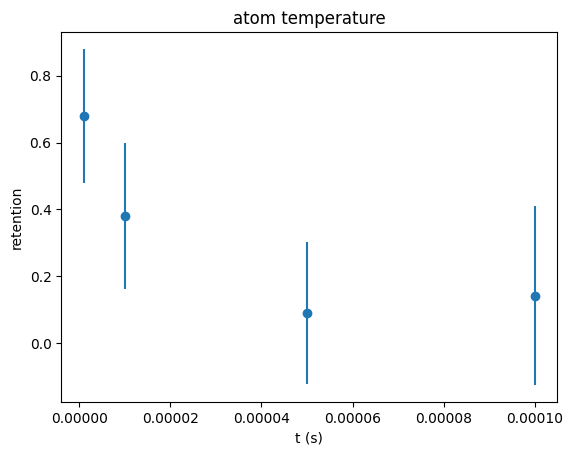

In [26]:
# plt.scatter(t_delay_arr/us, retention_array/retention_array[0])
# t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
# tau = 1.75
# plt.title('atom temperature')
# # plt.plot(t_pts,np.exp(-t_pts/tau),label=f"tau={tau} (s)")
# plt.ylabel("retention (normalized)")
# plt.xlabel("t (us)")
# # plt.xlim((0,1.1))
# # plt.legend()

plt.scatter(t_delay_arr, retention_array)
t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
plt.title('atom temperature')
plt.errorbar(t_delay_arr,retention_array,1/np.sqrt(n_atoms_loaded_array),ls='none')
plt.ylabel("retention")
plt.xlabel("t (s)")
# plt.xlim((0,1.1))
# plt.legend()

In [23]:
n_atoms_loaded_array

array([25., 21., 22., 14.])

In [15]:
retention_array

array([0.68      , 0.38095238, 0.09090909, 0.14285714])

Text(0.5, 0, 'minutes')

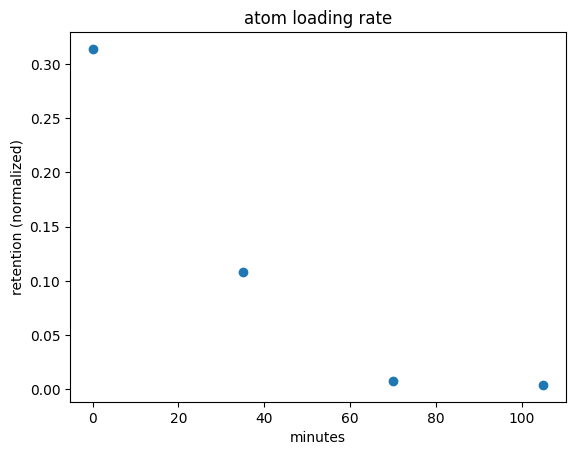

In [103]:
time = np.linspace(0,60+45,4)
plt.scatter(time,loading_rate_array)
plt.title('atom loading rate')
# plt.plot(t_pts,np.exp(-t_pts/tau),label=f"tau={tau} (s)")
plt.ylabel("retention (normalized)")
plt.xlabel("minutes")

In [ ]:
19

In [ ]:
plt.plot()

In [ ]:
# t_FORT_loading = np.single(f['archive']['t_FORT_loading'])
# photocounts = np.array(f['datasets']['photocounts'])[1:]
# measurements = np.uint(f['datasets']['n_measurements'])
# t_FORT_loading_list.append(t_FORT_loading)
# photocounts_list.append(photocounts)

# threshold = 260
# atoms = len(photocounts[photocounts>threshold])
# r_loading = atoms/len(photocounts)
# plt.hist(photocounts, bins=bins)#,alpha=0.5)
# plt.title(f't_FORT_loading={t_FORT_loading/0.001:.0f}ms, r_loading={r_loading:.2f}')
# plt.xlabel("photons")
# plt.ylabel("occurrences")
# # plt.savefig(f'atom_loading_20231012_{bins}_bins.pdf')
# plt.show()

In [24]:
ids = ['2023-10-23\\09\\000006656','2023-10-23\\09\\000006661','2023-10-23\\10\\000006663']
t_FORT_loading_list = []
photocounts_list = []
for id in ids:
    f = h5py.File(os.path.join(results, f'{id}-SimpleAtomTrapNoChop.h5'))
    # [x for x in f['datasets'].values()]
    t_FORT_loading = np.single(f['archive']['t_FORT_loading'])
    photocounts = np.array(f['datasets']['photocounts'])[1:]
    measurements = np.uint(f['datasets']['n_measurements'])
    t_FORT_loading_list.append(t_FORT_loading)
    photocounts_list.append(photocounts)

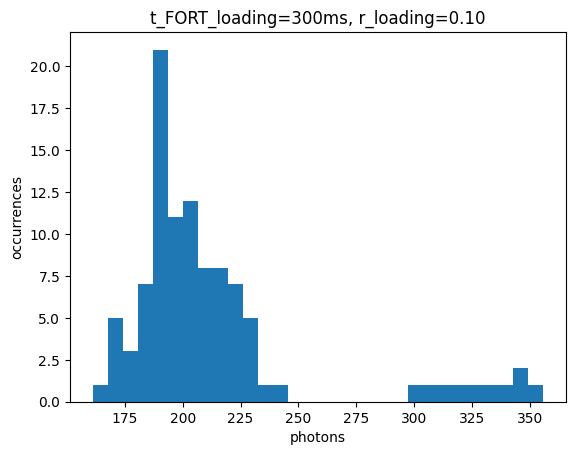

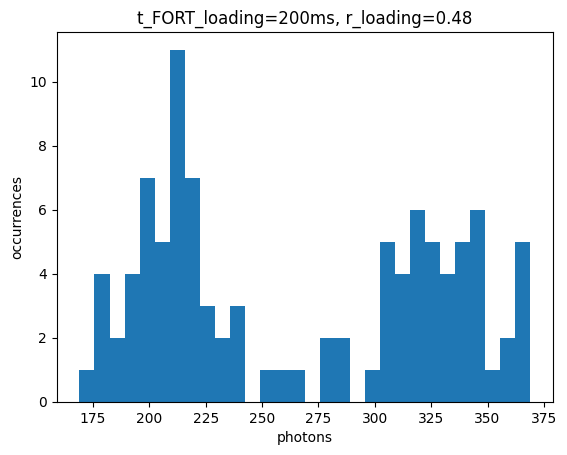

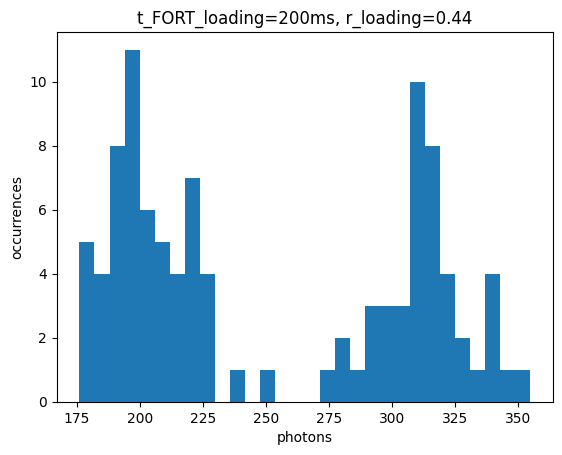

In [26]:
bins = 30
threshold = 270
for t_FORT_loading,photocounts in zip(t_FORT_loading_list,photocounts_list):
    atoms = len(photocounts[photocounts>threshold])
    r_loading = atoms/len(photocounts)
    plt.hist(photocounts, bins=bins)#,alpha=0.5)
    plt.title(f't_FORT_loading={t_FORT_loading/0.001:.0f}ms, r_loading={r_loading:.2f}')
    plt.xlabel("photons")
    plt.ylabel("occurrences")
    # plt.savefig(f'atom_loading_20231012_{bins}_bins.pdf')
    plt.show()

### 2023.10.20

today I checked the atom loading rate for different FORT loading times. the rate is noticeably too low at 100 ms, but seems okay at 200 ms or longer. probably somewhere between these is the sweet spot

In [16]:
ids = ['000006647','000006649','000006651']
t_FORT_loading_list = []
photocounts_list = []
for id in ids:
    f = h5py.File(os.path.join(results, f'2023-10-20\\13\\{id}-SimpleAtomTrapNoChop.h5'))
    # [x for x in f['datasets'].values()]
    t_FORT_loading = np.single(f['archive']['t_FORT_loading'])
    photocounts = np.array(f['datasets']['photocounts'])[1:]
    measurements = np.uint(f['datasets']['n_measurements'])
    t_FORT_loading_list.append(t_FORT_loading)
    photocounts_list.append(photocounts)

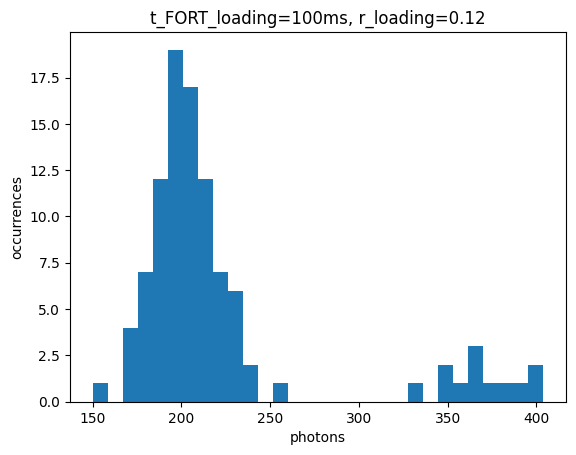

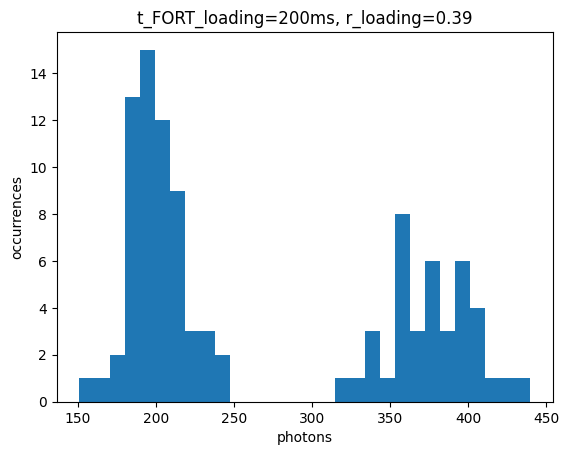

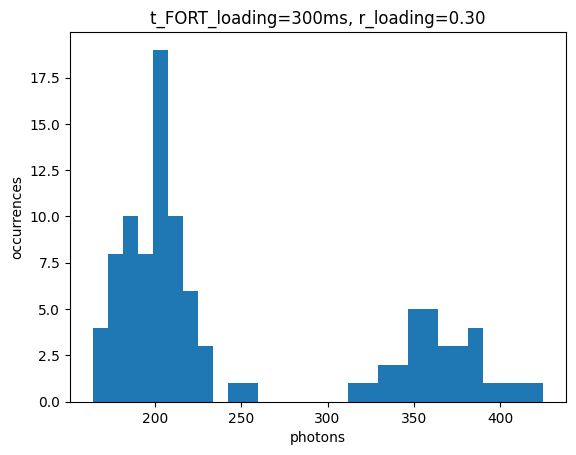

In [17]:
bins = 30
threshold = 300
for t_FORT_loading,photocounts in zip(t_FORT_loading_list,photocounts_list):
    atoms = len(photocounts[photocounts>threshold])
    r_loading = atoms/len(photocounts)
    plt.hist(photocounts, bins=bins)#,alpha=0.5)
    plt.title(f't_FORT_loading={t_FORT_loading/0.001:.0f}ms, r_loading={r_loading:.2f}')
    plt.xlabel("photons")
    plt.ylabel("occurrences")
    # plt.savefig(f'atom_loading_20231012_{bins}_bins.pdf')
    plt.show()

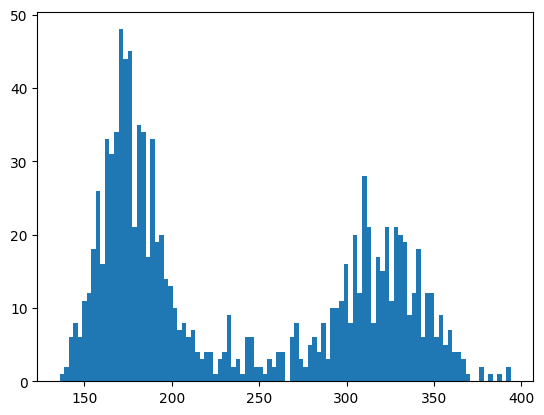

loading rate: 0.41


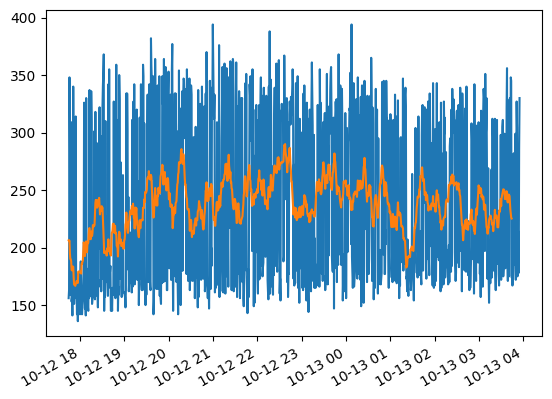

In [112]:
photocounts = photocounts_all
plt.hist(photocounts, bins=100,label='with MOT')
# plt.hist(photocounts_control, bins=100,label='no MOT', edgecolor=(1, 0.5, 0.2, 1), facecolor=(1, 0.5, 0.2, 0.5))
# plt.legend()
# plt.xlim((4000,5800))
plt.show()

pc = np.array(photocounts)
loading_rate = sum([1 for x in pc if x > 250])/len(pc)
print(f"loading rate: {loading_rate:.2f}")

plt.plot(datetimes,photocounts, label='with MOT')
avgs = 20
plt.plot(datetimes[:-avgs+1],np.convolve(photocounts,np.ones(avgs)/avgs,mode='valid'), label='rolling avg')
# plt.legend()
# plt.ylim((4000,5800))
plt.gcf().autofmt_xdate()
plt.show()

### 2023.10.13

last night I tested the persistence of atom loading over the course of 9 hours, doing an atom loading experiment every 30 s after feeding back to the MOT beams then loading a MOT for 1 s. The dipole trap was turned on for 300 ms, then the SPCM exposed for 10 ms. This is the same sequence which was used for the first atom loading experiment we did.

In [128]:
f = h5py.File(os.path.join(results, '2023-10-12\\17\\000006320-SimpleAtomTrapNoChop.h5'))
# [x for x in f['datasets'].values()]
t_exp = np.single(f['datasets']['dt_exposure'])
photocounts_all = list(f['datasets']['photocounts'])[1:]
measurements = np.uint(f['datasets']['n_measurements'])

# photocounts_control = [photocounts_all[i]/t_exp for i in range(len(photocounts_all)) if i%2==0]
# photocounts = [photocounts_all[i]/t_exp for i in range(len(photocounts_all)) if i%2==1]

In [129]:
t_exp

0.01

In [106]:
measurements

1080

In [107]:
# with open('first_single_photon_data.csv','w') as f:
#     writer = csv.writer(f)
#     writer.writerow(photocounts)

In [108]:
t_start = np.uint(f['run_time'])
t_end = time.mktime(dt.datetime(2023, 10, 13, 3, 55).timetuple())
datetimes = [dt.datetime.fromtimestamp(t) for t in np.linspace(t_start, t_end, len(photocounts_all))]

In [109]:
t_start

1697150672

In [120]:
os.getcwd()

'D:\\Networking Exp Data\\Atom loading histograms'

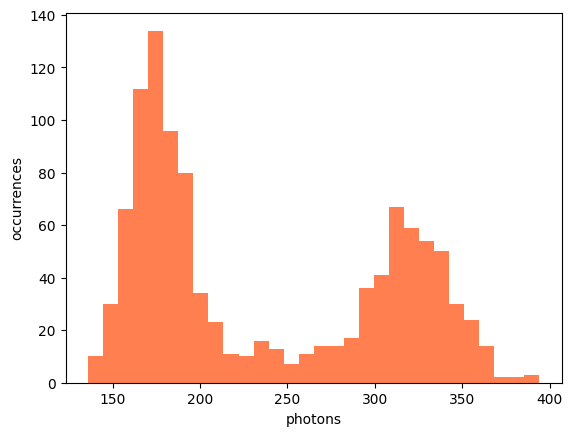

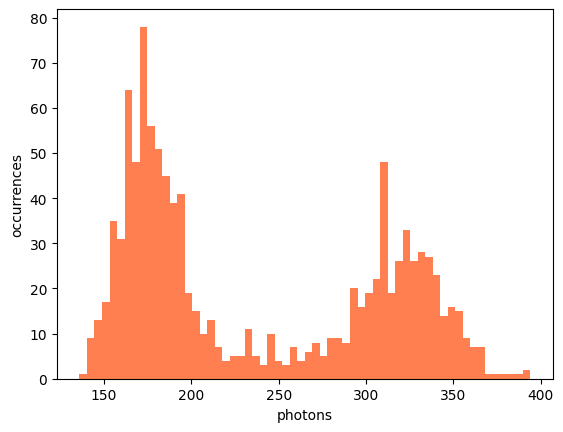

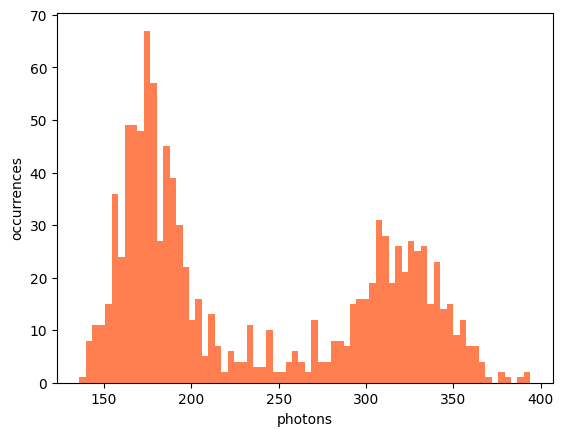

In [127]:
photocounts = photocounts_all
for bins in [30,60,70]:
    plt.hist(photocounts, bins=bins,label='with MOT',color='coral')
    plt.xlabel("photons")
    plt.ylabel("occurrences")
    # plt.savefig(f'atom_loading_20231012_{bins}_bins.pdf')
    plt.show()

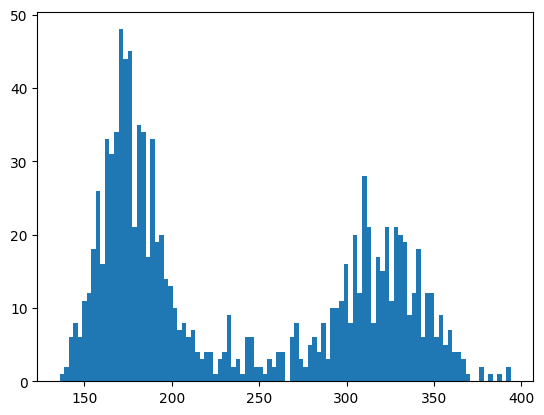

loading rate: 0.41


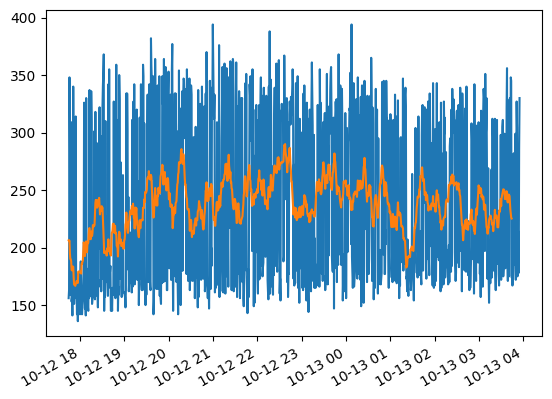

In [112]:
photocounts = photocounts_all
plt.hist(photocounts, bins=100,label='with MOT')
# plt.hist(photocounts_control, bins=100,label='no MOT', edgecolor=(1, 0.5, 0.2, 1), facecolor=(1, 0.5, 0.2, 0.5))
# plt.legend()
# plt.xlim((4000,5800))
plt.show()

pc = np.array(photocounts)
loading_rate = sum([1 for x in pc if x > 250])/len(pc)
print(f"loading rate: {loading_rate:.2f}")

plt.plot(datetimes,photocounts, label='with MOT')
avgs = 20
plt.plot(datetimes[:-avgs+1],np.convolve(photocounts,np.ones(avgs)/avgs,mode='valid'), label='rolling avg')
# plt.legend()
# plt.ylim((4000,5800))
plt.gcf().autofmt_xdate()
plt.show()

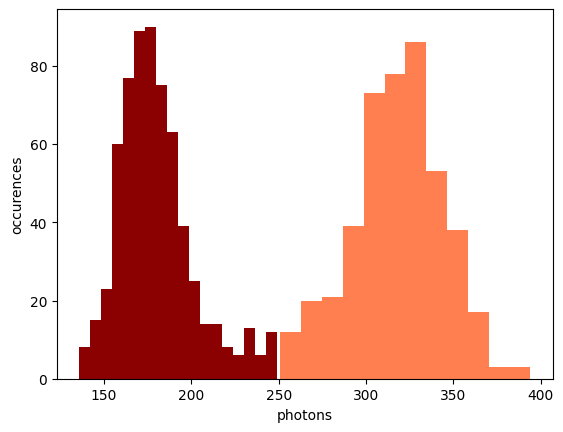

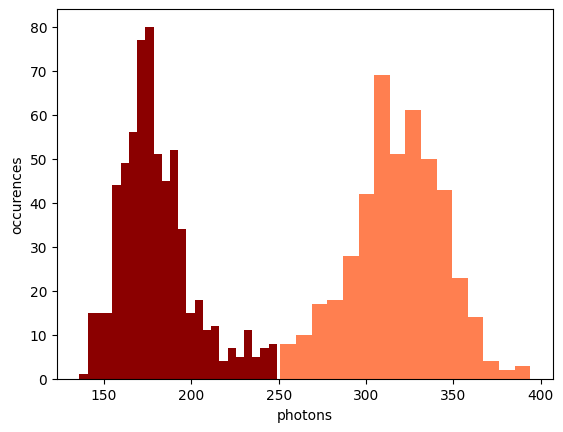

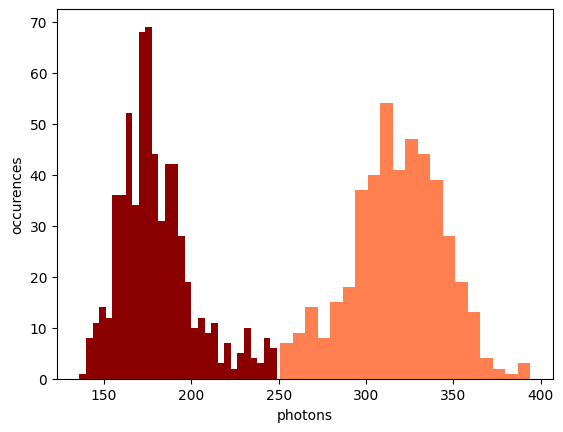

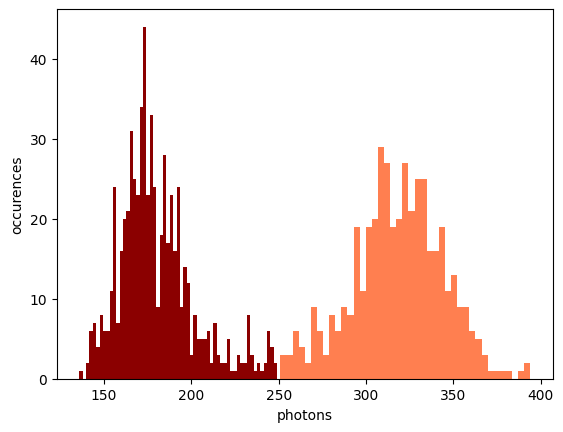

In [115]:
pc = np.array(photocounts)

threshold = 250
atoms = [x for x in pc if x > threshold]
no_atoms = [x for x in pc if x <= threshold]

for bins in [30,40,50,100]:
    atom_bins = int(bins*len(atoms)/len(pc))
    no_bins = bins - atom_bins
    plt.hist(atoms, bins=atom_bins,color='coral')
    plt.hist(no_atoms, bins=no_bins,color='darkred')
    plt.xlabel("photons")
    plt.ylabel("occurences")
    plt.show()

In [114]:
len(atoms)

0

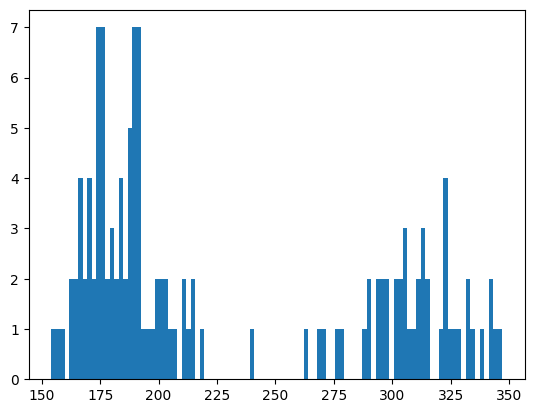

loading rate: 0.36



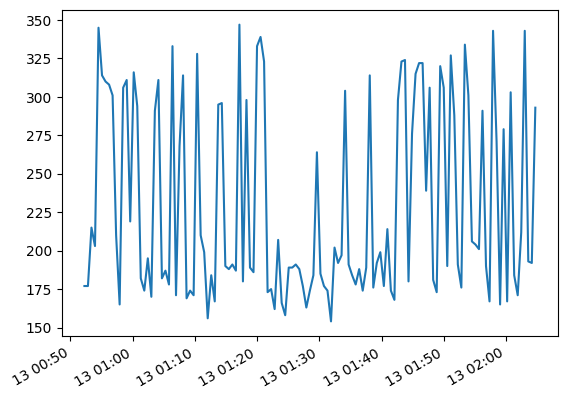

In [67]:
# limited range to see where loading drops out
photocounts = photocounts_all
istart = int(0.7*measurements)
iend = int(0.82*measurements)

plt.hist(photocounts[istart:iend], bins=100,label='with MOT')
# plt.hist(photocounts_control, bins=100,label='no MOT', edgecolor=(1, 0.5, 0.2, 1), facecolor=(1, 0.5, 0.2, 0.5))
# plt.legend()
# plt.xlim((4000,5800))
plt.show()

plt.plot(datetimes[istart:iend],photocounts[istart:iend], label='with MOT')

pc = np.array(photocounts[istart:iend])
loading_rate = sum([1 for x in pc if x > 250])/len(pc)
print(f"loading rate: {loading_rate:.2f}")

print()

avgs = 20
# plt.plot(datetimes[:-avgs],np.convolve(photocounts,np.ones(avgs)/avgs,mode='valid'), label='rolling avg')
# plt.legend()
# plt.ylim((4000,5800))
plt.gcf().autofmt_xdate()
plt.show()

### 2023.10.04

In [130]:
# f = h5py.File(os.path.join(results, '2023-10-04\\12\\000006030-SimpleAtomTrapNoChop.h5'))
f = h5py.File(os.path.join(results, '2023-10-04\\15\\000006055-SimpleAtomTrapNoChop.h5'))
# [x for x in f['datasets'].values()]
t_exp = np.single(f['datasets']['dt_exposure'])
photocounts_all = list(f['datasets']['photocounts'])[1:]
photocounts_control = [photocounts_all[i]/t_exp for i in range(len(photocounts_all)) if i%2==0]
photocounts = [photocounts_all[i]/t_exp for i in range(len(photocounts_all)) if i%2==1]

In [131]:
t_exp

0.01

In [70]:
with open('first_single_photon_data.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(photocounts)

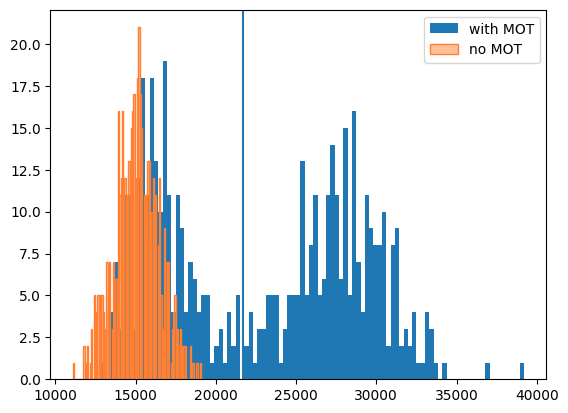

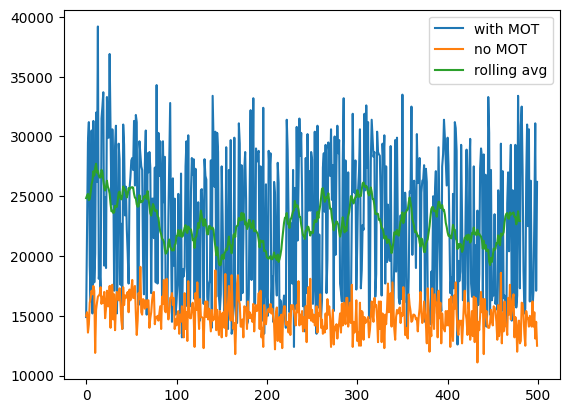

In [102]:
plt.hist(photocounts, bins=100,label='with MOT')
plt.hist(photocounts_control, bins=100,label='no MOT', edgecolor=(1, 0.5, 0.2, 1), facecolor=(1, 0.5, 0.2, 0.5))
plt.axvline(21700)
plt.legend()
# plt.xlim((4000,5800))
plt.show()

plt.plot(photocounts, label='with MOT')
plt.plot(photocounts_control, label='no MOT')
plt.plot(np.convolve(photocounts,np.ones(20)/20,mode='valid'), label='rolling avg')
plt.legend()
# plt.ylim((4000,5800))
plt.show()

In [93]:
int(bins*len(atoms)/len(pc))

17

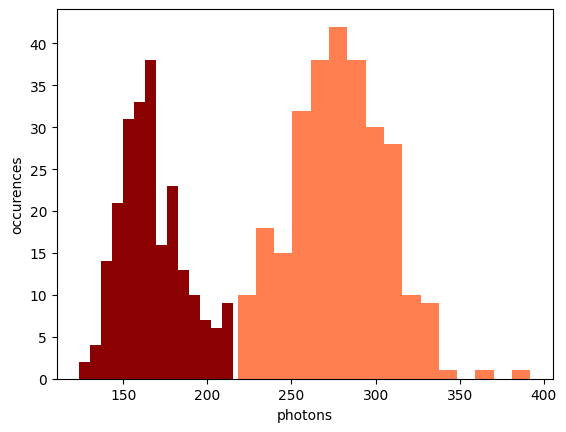

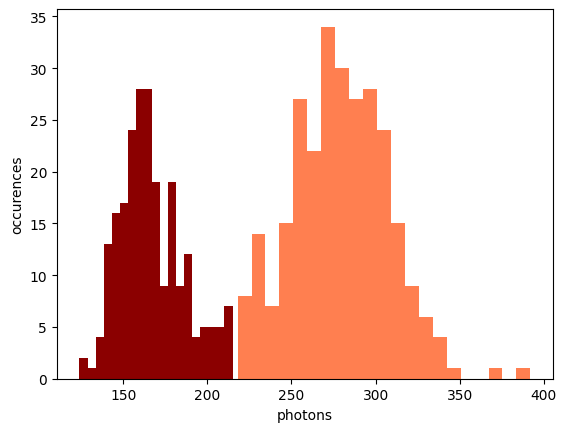

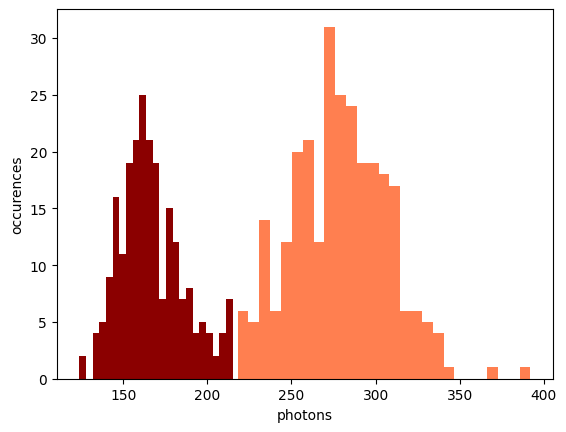

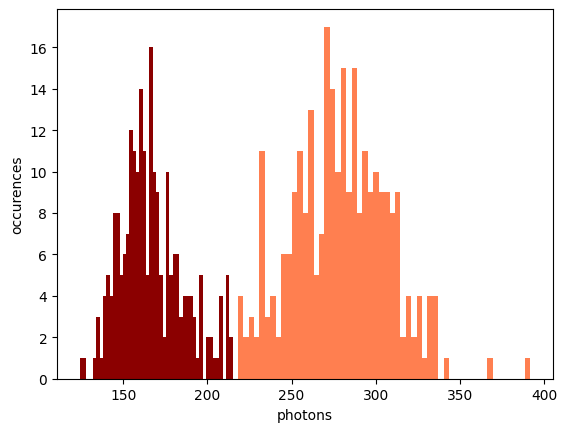

In [104]:
pc = np.array(photocounts)*0.01

threshold = 217
atoms = [x for x in pc if x > threshold]
no_atoms = [x for x in pc if x <= threshold]

for bins in [30,40,50,100]:
    atom_bins = int(bins*len(atoms)/len(pc))
    no_bins = bins - atom_bins
    plt.hist(atoms, bins=atom_bins,color='coral')
    plt.hist(no_atoms, bins=no_bins,color='darkred')
    plt.xlabel("photons")
    plt.ylabel("occurences")
    plt.show()

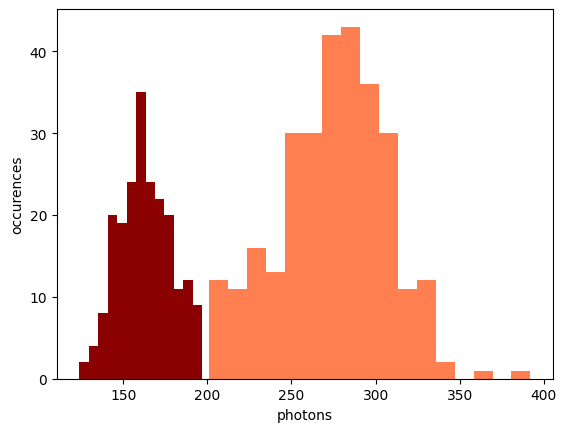

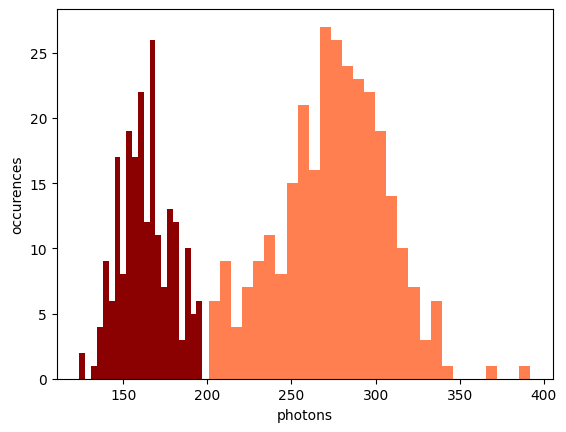

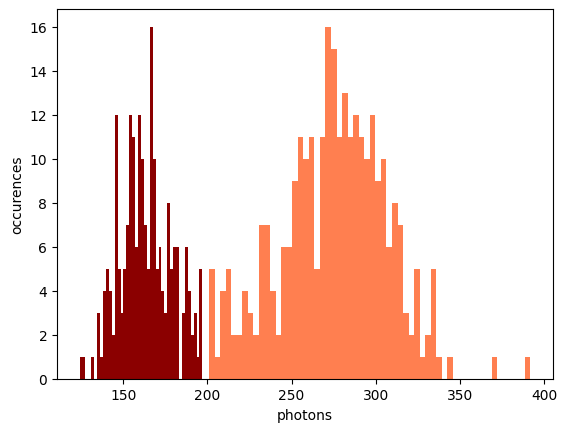

In [94]:
pc = np.array(photocounts)*0.01

threshold = 200
atoms = [x for x in pc if x > threshold]
no_atoms = [x for x in pc if x <= threshold]

for bins in [30,50,100]:
    atom_bins = int(bins*len(atoms)/len(pc))
    no_bins = bins - atom_bins
    plt.hist(atoms, bins=atom_bins,color='coral')
    plt.hist(no_atoms, bins=no_bins,color='darkred')
    plt.xlabel("photons")
    plt.ylabel("occurences")
    plt.show()

## September 2023

### 2023.09.12

In [176]:
t_exp = 0.01
f = h5py.File(os.path.join(results, '2023-09-12\\14\\000005182-SimpleAtomTrapNoChopCoilTune.h5'))
# [x for x in f['datasets'].values()]
photocounts_all = list(f['datasets']['photocounts'])[1:]
photocounts_control = [photocounts_all[i]/t_exp for i in range(len(photocounts_all)) if i%2==0]
photocounts = [photocounts_all[i]/t_exp for i in range(len(photocounts_all)) if i%2==1]

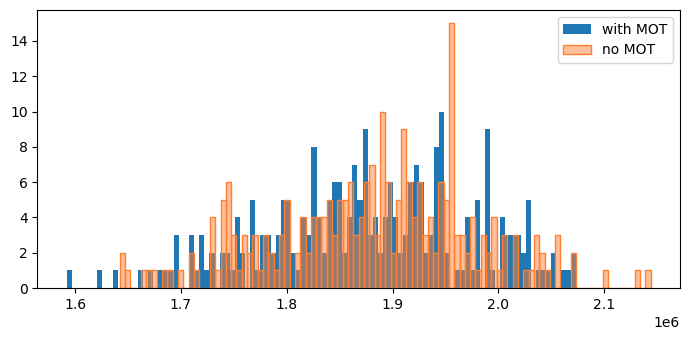

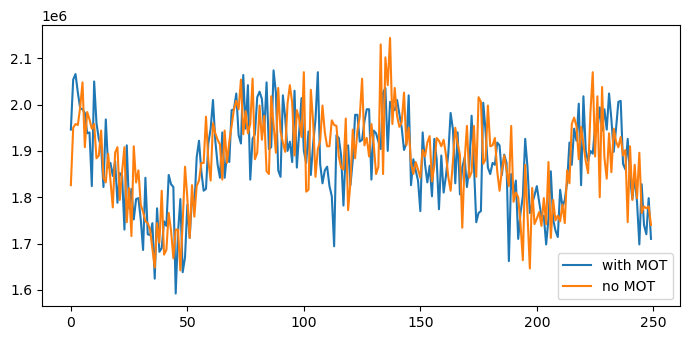

In [177]:
plt.hist(photocounts, bins=100,label='with MOT')
plt.hist(photocounts_control, bins=100,label='no MOT', edgecolor=(1, 0.5, 0.2, 1), facecolor=(1, 0.5, 0.2, 0.5))
plt.legend()
# plt.xlim((4000,5800))
plt.show()

plt.plot(photocounts, label='with MOT')
plt.plot(photocounts_control, label='no MOT')
plt.legend()
# plt.ylim((4000,5800))
plt.show()

### 2023.09.12

In [174]:
t_exp = 0.01
f = h5py.File(os.path.join(results, '2023-09-12\\13\\000005180-SimpleAtomTrapNoChopCoilTune.h5'))
# [x for x in f['datasets'].values()]
photocounts_all = list(f['datasets']['photocounts'])[1:]
photocounts_control = [photocounts_all[i]/t_exp for i in range(len(photocounts_all)) if i%2==0]
photocounts = [photocounts_all[i]/t_exp for i in range(len(photocounts_all)) if i%2==1]

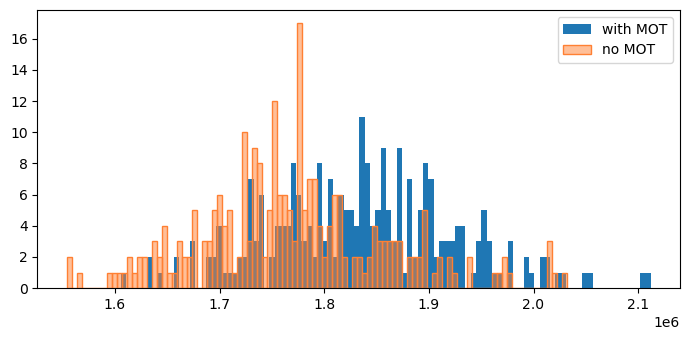

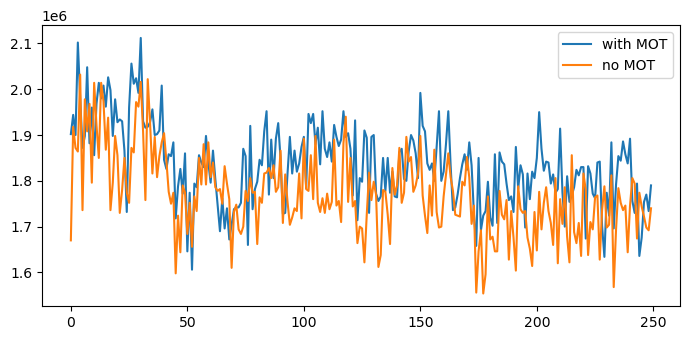

In [175]:
plt.hist(photocounts, bins=100,label='with MOT')
plt.hist(photocounts_control, bins=100,label='no MOT', edgecolor=(1, 0.5, 0.2, 1), facecolor=(1, 0.5, 0.2, 0.5))
plt.legend()
# plt.xlim((4000,5800))
plt.show()

plt.plot(photocounts, label='with MOT')
plt.plot(photocounts_control, label='no MOT')
plt.legend()
# plt.ylim((4000,5800))
plt.show()

### 2023.09.07

this shows that there is no signal from the MOT, since the control signal from the SPCM is the same as when there is a MOT 
(the SPCM exposure happened with the MOT still on). The FORT background is about 12000 cts/s and the fluorescence is about
6000, so ~ 18000 makes sense.

In [171]:
t_exp = 0.01
f = h5py.File(os.path.join(results, '2023-09-07\\11\\000005068-SimpleAtomTrapNoChop.h5'))
# [x for x in f['datasets'].values()]
photocounts_all = list(f['datasets']['photocounts'])[1:]
photocounts_control = [photocounts_all[i]/t_exp for i in range(len(photocounts_all)) if i%2==0]
photocounts = [photocounts_all[i]/t_exp for i in range(len(photocounts_all)) if i%2==1]

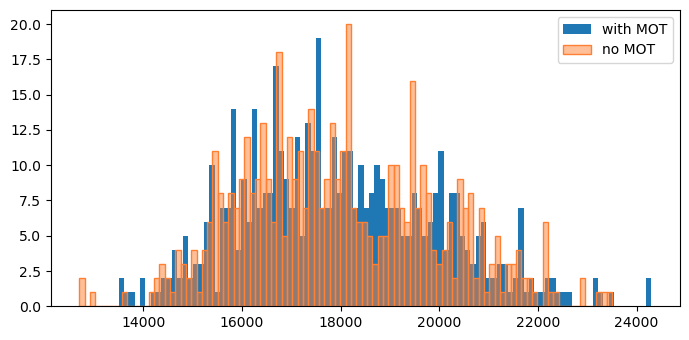

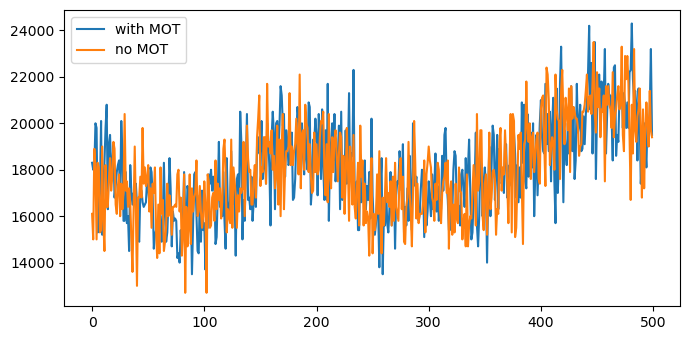

In [172]:
plt.hist(photocounts, bins=100,label='with MOT')
plt.hist(photocounts_control, bins=100,label='no MOT', edgecolor=(1, 0.5, 0.2, 1), facecolor=(1, 0.5, 0.2, 0.5))
plt.legend()
# plt.xlim((4000,5800))
plt.show()

plt.plot(photocounts, label='with MOT')
plt.plot(photocounts_control, label='no MOT')
plt.legend()
# plt.ylim((4000,5800))
plt.show()

### 2023.09.05

control is with the y shim offset to intentionally lose the MOT

In [108]:
f = h5py.File(os.path.join(results, '2023-09-05\\17\\000004965-SimpleAtomTrapNoChop.h5'))
# [x for x in f['datasets'].values()]
photocounts_all = list(f['datasets']['photocounts'])[1:]
photocounts_control = [photocounts_all[i] for i in range(len(photocounts_all)) if i%2==0]
photocounts = [photocounts_all[i] for i in range(len(photocounts_all)) if i%2==1]

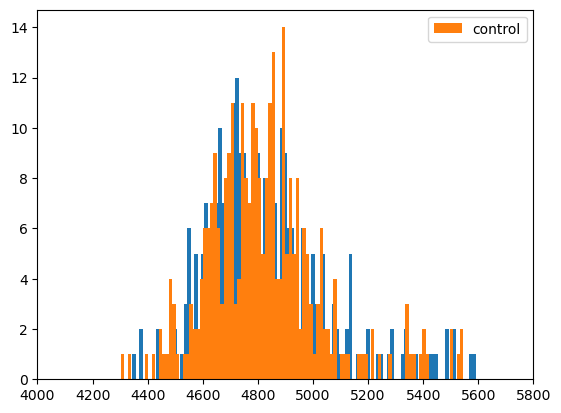

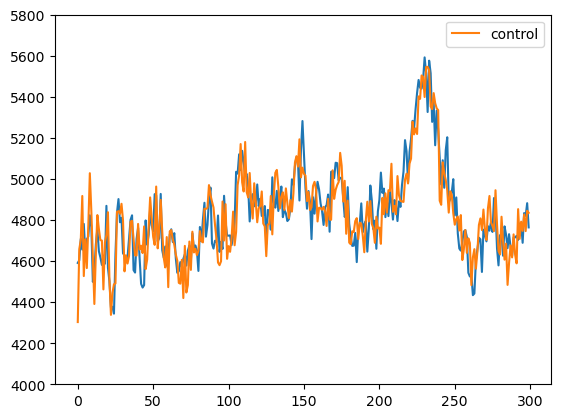

In [113]:
plt.hist(photocounts, bins=100)
plt.hist(photocounts_control, bins=100,label='control')
plt.legend()
plt.xlim((4000,5800))
plt.show()
plt.plot(photocounts)
plt.plot(photocounts_control,label='control')
plt.legend()
plt.ylim((4000,5800))
plt.show()

control experiment with coil off every other iteration

In [102]:
f = h5py.File(os.path.join(results, '2023-09-05\\15\\000004941-SimpleAtomTrapNoChop.h5'))
# [x for x in f['datasets'].values()]
photocounts_all = list(f['datasets']['photocounts'])[1:]
photocounts_control = [photocounts_all[i] for i in range(len(photocounts_all)) if i%2==0]
photocounts = [photocounts_all[i] for i in range(len(photocounts_all)) if i%2==1]

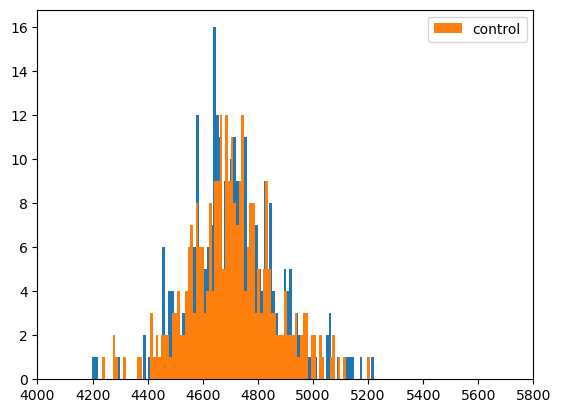

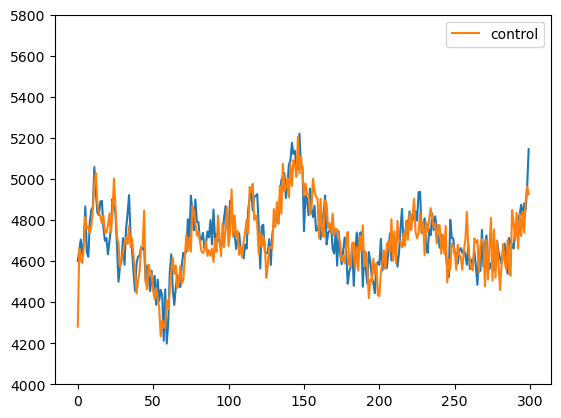

In [105]:
plt.hist(photocounts, bins=100)
plt.hist(photocounts_control, bins=100,label='control')
plt.legend()
plt.xlim((4000,5800))
plt.show()
plt.plot(photocounts)
plt.plot(photocounts_control,label='control')
plt.legend()
plt.ylim((4000,5800))
plt.show()

control experiment with the RP off. the data indicates that the SPCM signal is not actually from the MOT, despite what I saw with the SamplerCoilTune run just before running these. So apparently it drifts.

In [96]:
f = h5py.File(os.path.join(results, '2023-09-05\\13\\000004921-SimpleAtomTrapNoChop.h5'))
# [x for x in f['datasets'].values()]
photocounts_noRP = list(f['datasets']['photocounts'])[1:]

f = h5py.File(os.path.join(results, '2023-09-05\\13\\000004920-SimpleAtomTrapNoChop.h5'))
# [x for x in f['datasets'].values()]
photocounts = list(f['datasets']['photocounts'])[1:]

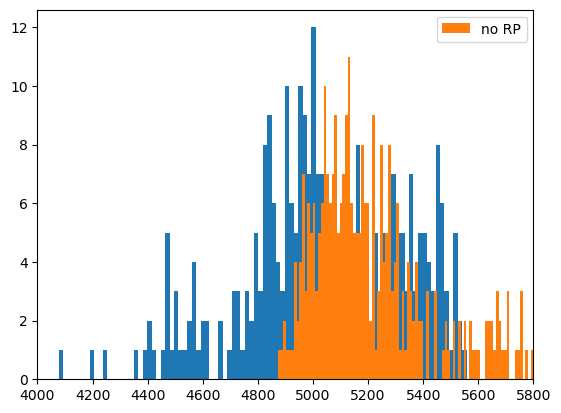

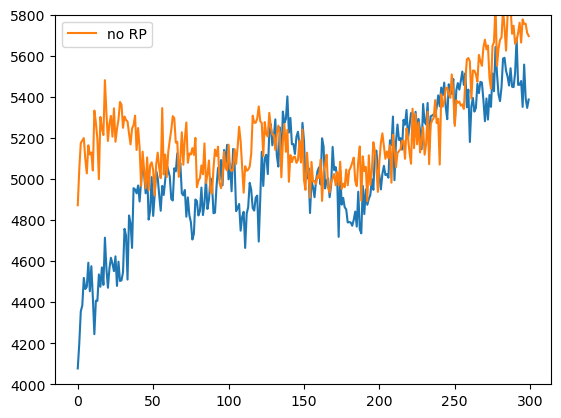

In [98]:
plt.hist(photocounts, bins=100)
plt.hist(photocounts_noRP, bins=100,label='no RP')
plt.legend()
plt.xlim((4000,5800))
plt.show()
plt.plot(photocounts)
plt.plot(photocounts_noRP,label='no RP')
plt.legend()
plt.ylim((4000,5800))
plt.show()

In [ ]:
atom loading experiment

In [91]:
f = h5py.File(os.path.join(results, '2023-09-05\\13\\000004920-SimpleAtomTrapNoChop.h5'))
# [x for x in f['datasets'].values()]
photocounts = list(f['datasets']['photocounts'])[1:]

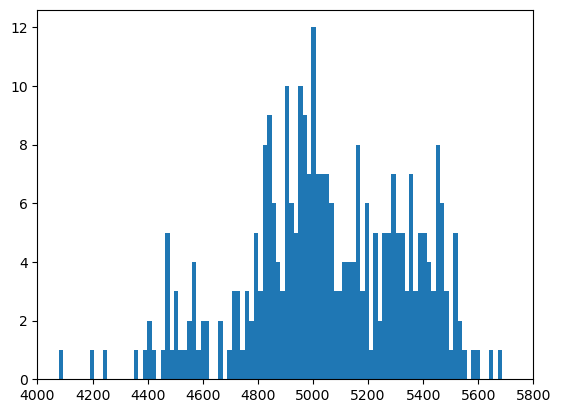

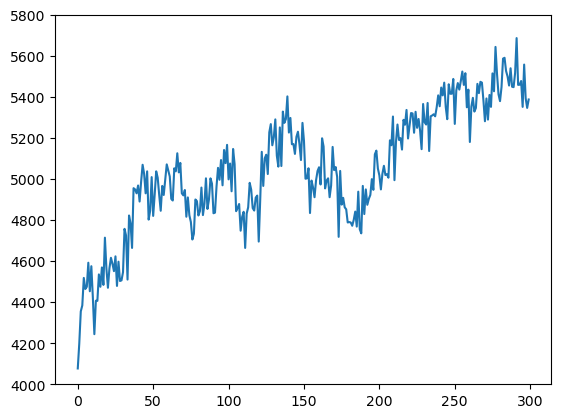

In [92]:
plt.hist(photocounts, bins=100)
plt.xlim((4000,5800))
plt.show()
plt.plot(photocounts)
plt.ylim((4000,5800))
plt.show()

In [ ]:
plt.

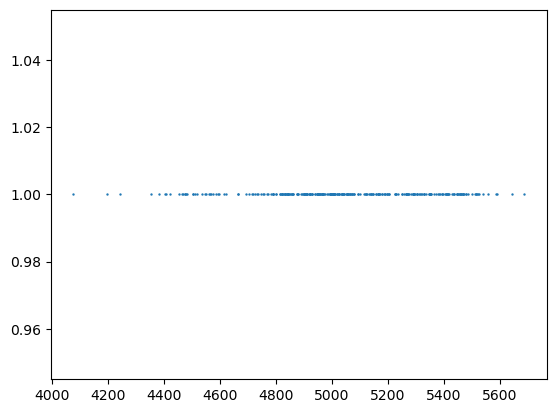

In [71]:
plt.scatter(photocounts,[1]*len(photocounts),s=0.5)

In [ ]:
ax=plt.contour(photocounts)
fig.colorbar()

### 2023.09.04

control experiment with the FORT off shows that most of the background is just from the FORT being on. This should be fixed before proceeding, most likely.

In [45]:
f = h5py.File(os.path.join(results, '2023-09-04\\16\\000004869-SimpleAtomTrapNoChop.h5'))
# [x for x in f['datasets'].values()]
photocounts = list(f['datasets']['photocounts'])[1:]

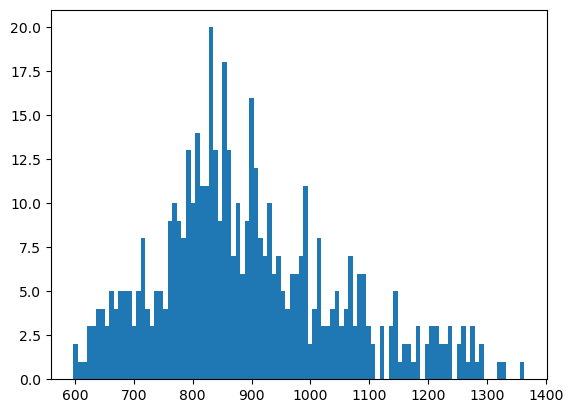

In [46]:
plt.hist(photocounts, bins=100)
plt.show()

In [48]:
f = h5py.File(os.path.join(results, '2023-09-04\\15\\000004868-SimpleAtomTrapNoChop.h5'))
# [x for x in f['datasets'].values()]
photocounts = list(f['datasets']['photocounts'])[1:]

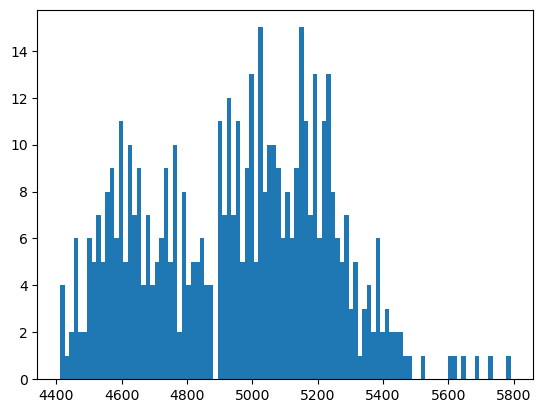

In [51]:
plt.hist(photocounts, bins=100)
plt.show()

In [30]:
[x for x in f['datasets'].values()]

[<HDF5 dataset "AOM_A1_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A2_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A3_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A4_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A5_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A6_power": shape (), type "<f8">,
 <HDF5 dataset "MOT1_monitor": shape (71,), type "<f8">,
 <HDF5 dataset "MOT2_monitor": shape (71,), type "<f8">,
 <HDF5 dataset "MOT3_monitor": shape (71,), type "<f8">,
 <HDF5 dataset "MOT4_monitor": shape (71,), type "<f8">,
 <HDF5 dataset "MOT5_monitor": shape (71,), type "<f8">,
 <HDF5 dataset "MOT6_monitor": shape (71,), type "<f8">,
 <HDF5 dataset "MOT_switchyard_monitor": shape (71,), type "<f8">,
 <HDF5 dataset "monitor_pts": shape (1,), type "<i4">,
 <HDF5 dataset "p_cooling_DP_MOT": shape (), type "<f8">,
 <HDF5 dataset "photocount_bins": shape (1,), type "<i4">,
 <HDF5 dataset "photocounts": shape (501,), type "<i4">]

In [31]:
MOTdata = [np.array(data) for data in  f['datasets'].values()][6:13]

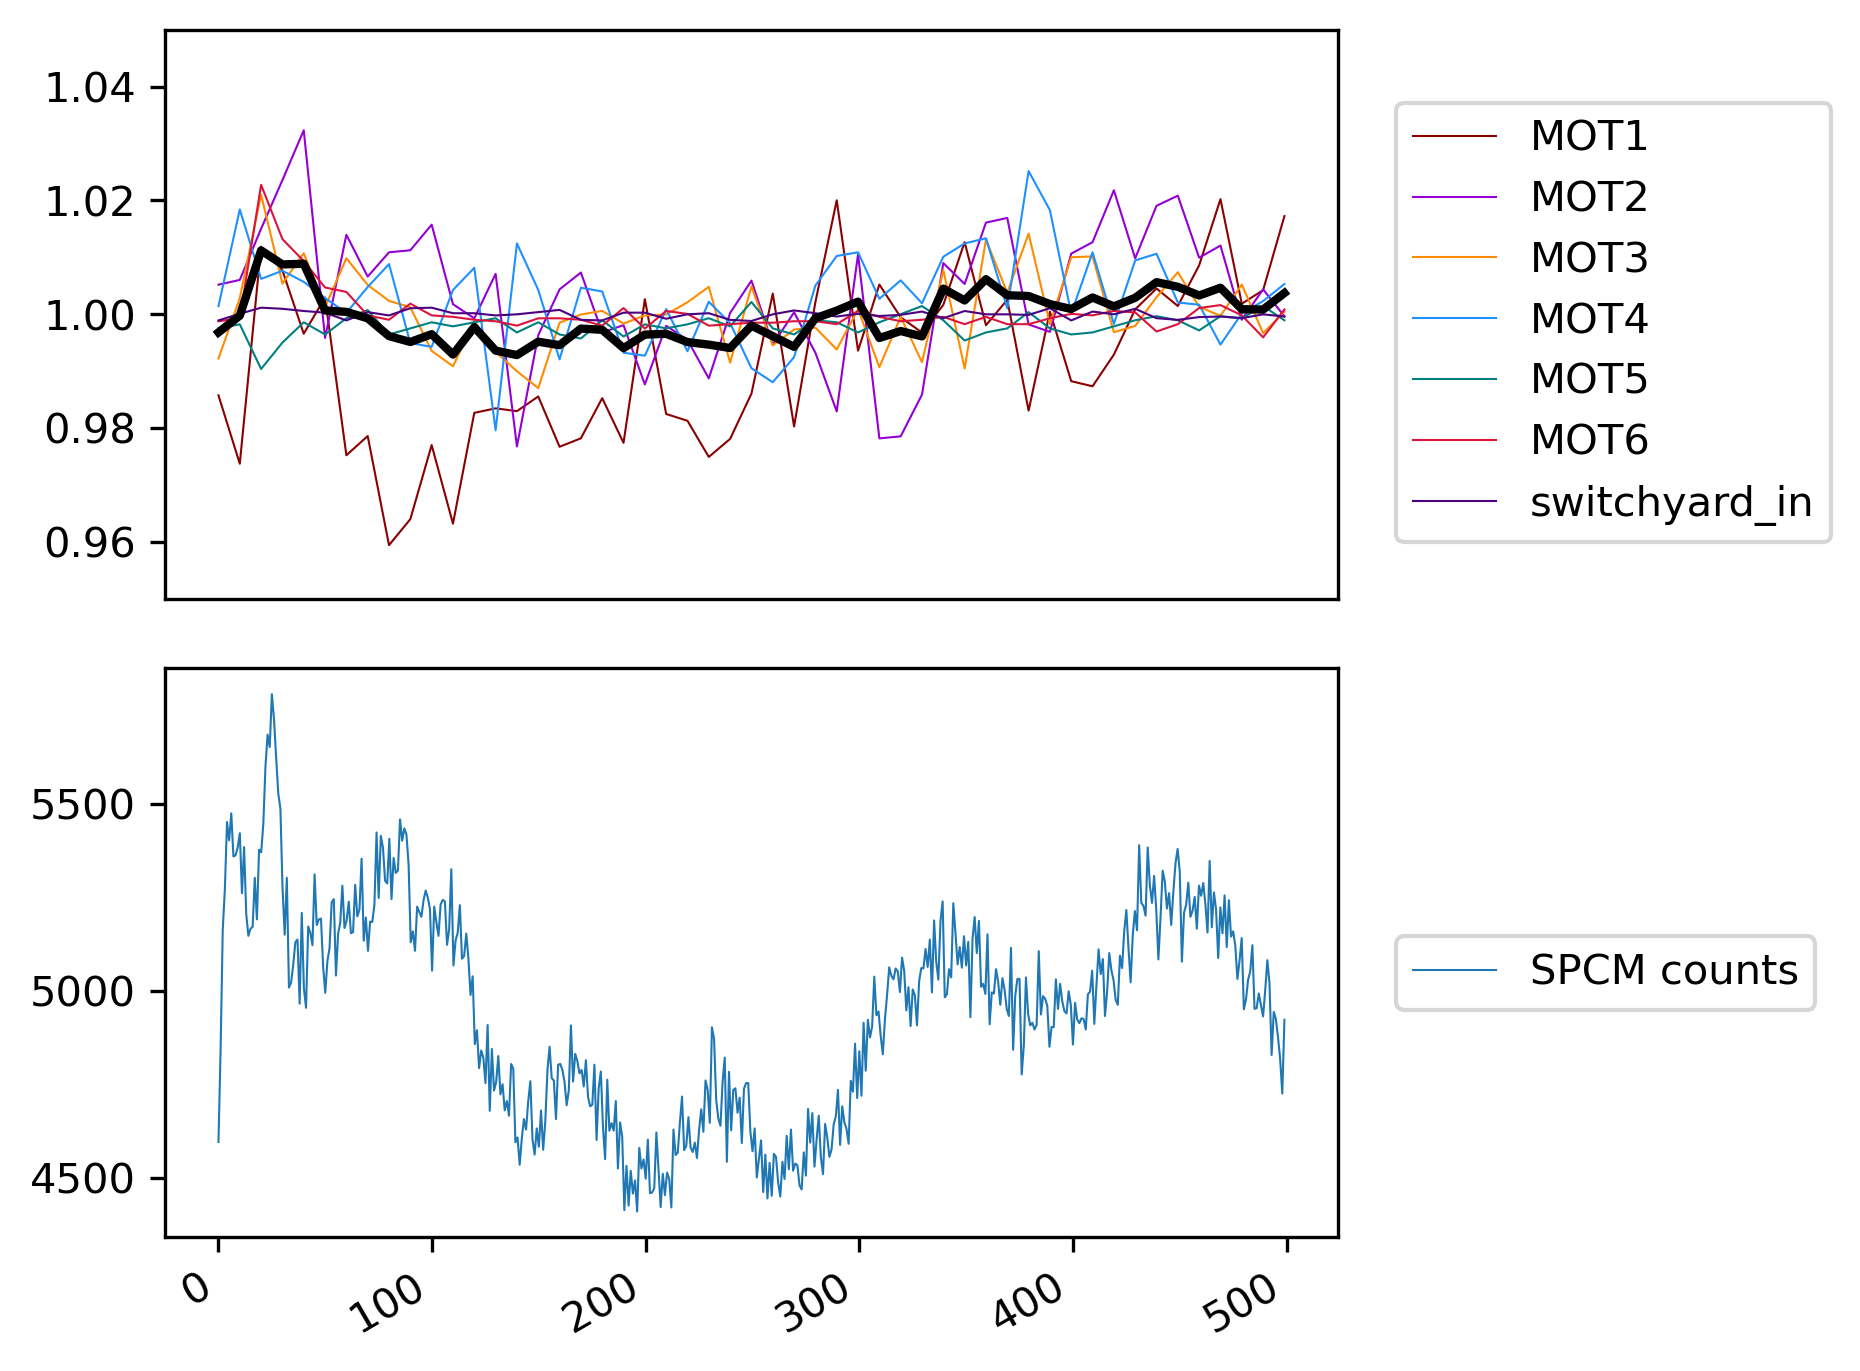

In [44]:
labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=2,dpi=300)
ax, ax2 = axes
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for label,data,color in zip(labels,MOTdata,colors):
    ypts = data[20:] # the feedback runs 20 times before we start counting photons
    xpts = range(len(ypts))
#     ax.scatter(xpts, ypts, color=color,s=0.1)
    ax.plot(xpts, ypts, color=color, label=label,linewidth=0.5)
    ax.set_ylim((0.95,1.05))
    ax.legend(loc=(1.05,0.1))
ax.get_xaxis().set_visible(False)
counts_steps = len(photocounts)

ax.plot(np.mean([x[20:] for x in MOTdata[:-1]],axis=0),linewidth=2,c='k')

ax2.plot(range(counts_steps),photocounts,label='SPCM counts',linewidth=0.5)
# ax2.set_xticks(timestamps)
plt.gcf().autofmt_xdate()
ax2.legend(loc=(1.05,0.4))
fig.tight_layout()

## May 2023

In [30]:
expdir = "C:\\Networking Experiment\\artiq codes\\artiq-master\\repository\\qn_artiq_routines\\analysis\\csv_data\\"
datafile = os.path.join(expdir,"results\\20230531_083727_atom_loading_counts.csv") # no FORT

has_header = True
with open(datafile, 'r', newline='') as f:
    reader = csv.reader(f)
    if has_header:
        header = reader.__next__()
    data = [row for row in reader]
    f.close()

data = np.array(data,float).transpose()
rows,cols = data.shape
print("rows:", rows, "cols:", cols)

counts = data[0]

rows: 1 cols: 200


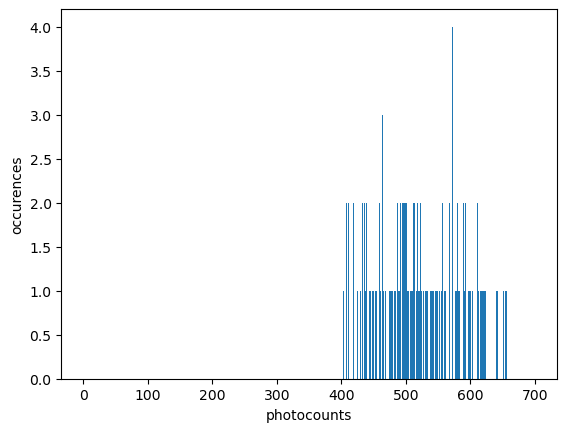

In [29]:
fig, ax = plt.subplots()
# bins = np.linspace(int(min(counts))-10,int(max(counts))+10,int(max(counts))-int(min(counts))+20)
bins = np.linspace(1,700,700)
ax.hist(counts,bins=bins)
ax.set_xlabel("photocounts")
ax.set_ylabel("occurences")
plt.show()

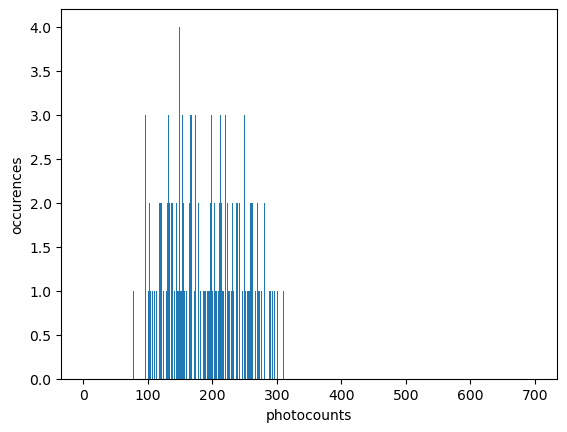

In [31]:
fig, ax = plt.subplots()
# bins = np.linspace(int(min(counts))-10,int(max(counts))+10,int(max(counts))-int(min(counts))+20)
bins = np.linspace(1,700,700)
ax.hist(counts,bins=bins)
ax.set_xlabel("photocounts")
ax.set_ylabel("occurences")
plt.show()

In [9]:
ax.hist?